<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/solutions/hw3_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 32.89 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
--2020-12-02 17:32:12--  https://docs.google.com/uc?export=download&confirm=B7Xz&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 74.125.142.113, 74.125.142.101, 74.125.142.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-84-docs.googleusercontent.com/docs/securesc/d8al4darmb6flgf7qkcpo5pojg4mqos0/a14c3kkc0lfv2n3h39943eco7fhcc0m6/1606930275000/06419056966375271799/06115639060730575572Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2020-12-02 17:32:12-

In [10]:
from deepul.hw3_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


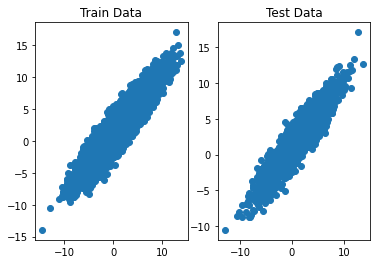

Dataset 2


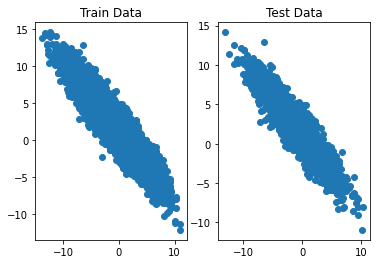

In [11]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [102]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
from tqdm.autonotebook import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [44]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, num_epochs=10, lr=1e-2, clip_grad=2):
        self.model = model
        self.optimizer = Adam(model.parameters(), lr)
        self.lr = lr
        self.clip_grad = clip_grad
        self.num_epochs = num_epochs
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        train_losses, test_losses = OrderedDict(), OrderedDict()
        pbar = tqdm(range(self.num_epochs), total=self.num_epochs)
        for epoch in pbar:
            train_loss = self.train_epoch()
            test_loss = self.eval_epoch()

            for key in train_loss:
                if key not in train_losses:
                    train_losses[key] = []
                    test_losses[key] = []
                train_losses[key].extend(train_loss[key])
                test_losses[key].append(test_loss[key])
            
            pbar.set_postfix_str(f'Epoch #{epoch}, test loss: {test_loss["loss"]:.4f}')

        return train_losses, test_losses

    def train_epoch(self):
        self.model.train()
        
        train_losses = {}
        for x in self.train_loader:
            out = self.model.compute_loss(x.to(device).contiguous())
            self.optimizer.zero_grad()
            out['loss'].backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)
            self.optimizer.step()

            for key, val in out.items():
                if key not in train_losses:
                    train_losses[key] = []
                train_losses[key].append(val.item())

        return train_losses

    def eval_epoch(self):
        self.model.eval()

        eval_losses = {}
        with torch.no_grad():
            for x in self.test_loader:
                out = self.model.compute_loss(x.to(device).contiguous())

                for key, val in out.items():
                    eval_losses[key] = eval_losses.get(key, 0) + val.item() * x.size(0)

            for key in eval_losses:
                eval_losses[key] /= len(self.test_loader.dataset)

        return eval_losses

In [106]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, hidden_dim1=128, hidden_dim2=64):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, 2 * latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, 2 * input_dim)
        )

    def compute_loss(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        mu_z, log_std_z = self.encoder(x).view(batch_size, 2 * self.latent_dim).chunk(2, dim=1)
        
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        z = z.view(batch_size, -1)
        mu_x, log_std_x = self.decoder(z).view(batch_size, 2 * self.input_dim).chunk(2, dim=1)
        
        rec_loss = -Normal(mu_x, log_std_x.exp()).log_prob(x)
        kl_loss = -log_std_z - 0.5 + (log_std_z.exp() ** 2 + mu_z ** 2) * 0.5
        rec_loss = rec_loss.sum(1).mean()
        kl_loss = kl_loss.sum(1).mean()

        return {'loss': rec_loss + kl_loss, 'rec_loss': rec_loss, 'kl_loss': kl_loss}

    def sample(self, n, with_noise=False):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda()
            x, log_std = self.decoder(z).chunk(2, dim=1)
            if with_noise:
                x = torch.randn_like(x) * log_std.exp() + x

        return x.cpu().numpy()

In [107]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """ 

    model = VAE().to(device)

    train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=512)
    trainer = Trainer(model, train_loader, test_loader, 20, 1e-3)
    train_losses, test_losses = trainer.train()

    train_losses = np.stack((train_losses['loss'], 
                             train_losses['rec_loss'], 
                             train_losses['kl_loss']), 
                            axis=1)
    test_losses = np.stack((test_losses['loss'], 
                            test_losses['rec_loss'], 
                            test_losses['kl_loss']), 
                           axis=1)

    samples_noise = model.sample(1000, with_noise=True)
    samples_without_noise = model.sample(1000)

    return train_losses, test_losses, samples_noise, samples_without_noise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.


Final -ELBO: 4.4450, Recon Loss: 2.8445, KL Loss: 1.6005


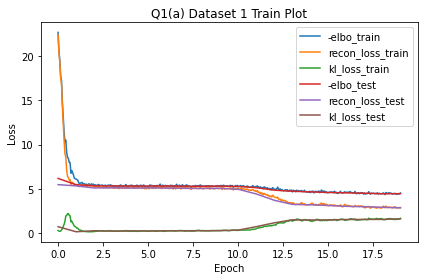

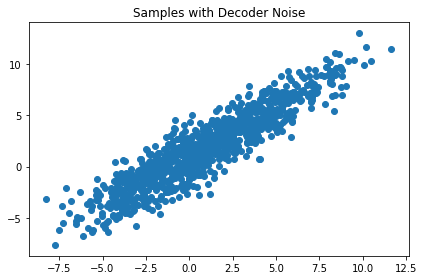

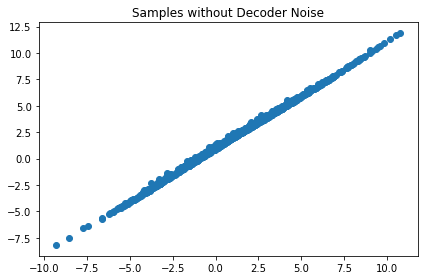

In [108]:
q1_save_results('a', 1, q1)


Final -ELBO: 4.4767, Recon Loss: 2.8845, KL Loss: 1.5922


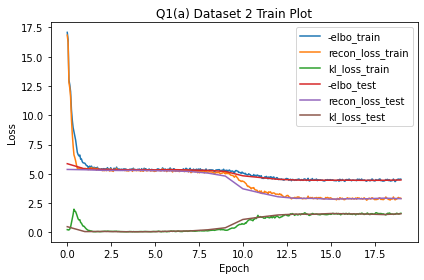

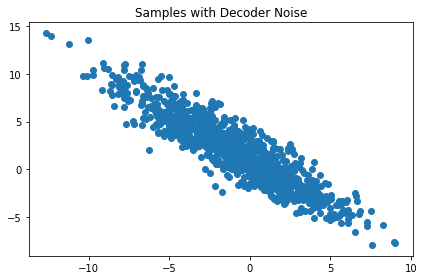

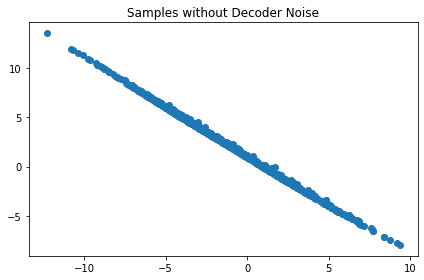

In [109]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


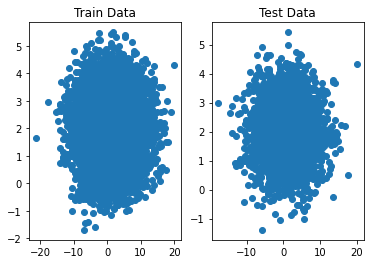

Dataset 2


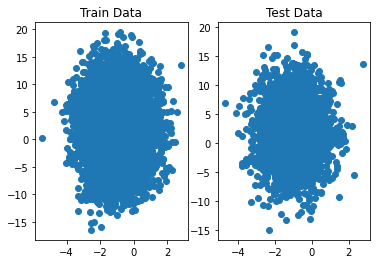

In [110]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.


Final -ELBO: 4.4219, Recon Loss: 4.4166, KL Loss: 0.0053


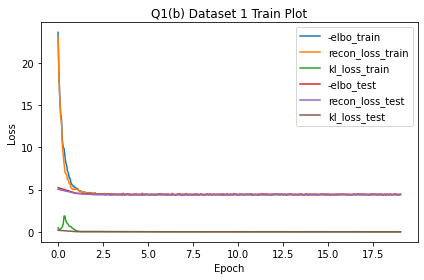

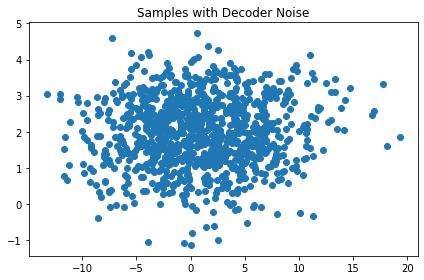

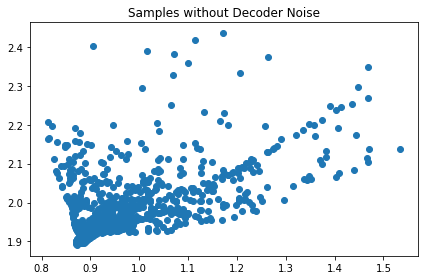

In [111]:
q1_save_results('b', 1, q1)


Final -ELBO: 4.4209, Recon Loss: 4.4146, KL Loss: 0.0063


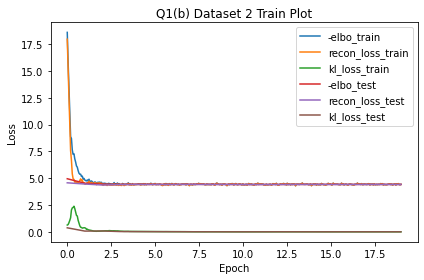

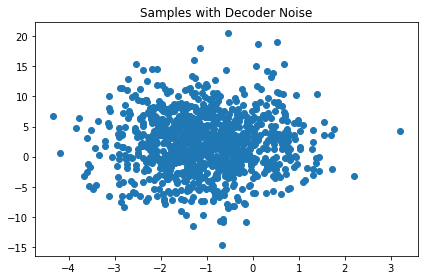

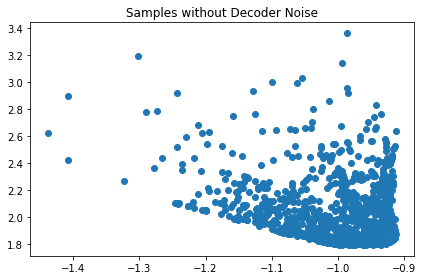

In [112]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

Answer: The latents are being used in part (a), but not in part (b). This is because the dataset in part (a) comes from a diagonal gaussian distribution so the decoder (also diagonal gaussian) can optimally model the data without the encoder / latents. However, for (a), the data come from a multivariate gaussian with non-diagonal covariance, so the encoder is used to achieve a better loss than without.

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

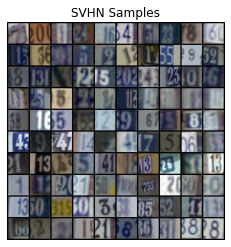

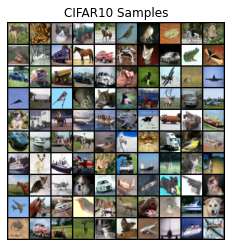

In [64]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [88]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # 32 // 8 = 4
        )
        self.fc = nn.Linear(4 * 4 * 256, 2 * latent_dim)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x).chunk(2, dim=1)

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.fc = nn.Sequential( 
            nn.Linear(latent_dim, 128 * 4 * 4),
            nn.ReLU()
        )
        self.decnn = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 256, 4, 4)
        return self.decnn(x)


class ConvVAE(nn.Module):
    def __init__(self, latent_size=16):
        super().__init__()
        self.latent_size = latent_size
        self.encoder = ConvEncoder(latent_size)
        self.decoder = ConvDecoder(latent_size)

    def compute_loss(self, x):
        x = 2 * x - 1 # normalize from -1 to 1
        mu, log_std = self.encoder(x)
        z = torch.randn_like(mu) * log_std.exp() + mu
        out = self.decoder(z)

        rec_loss = F.mse_loss(x, out, reduction='none').view(x.size(0), -1).sum(1).mean()
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return  {'loss': rec_loss + kl_loss, 'rec_loss': rec_loss, 'kl_loss': kl_loss}

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).to(device)
            x = self.decoder(z)
        
        return (np.clip(x.cpu().numpy(), -1, 1) * 0.5 + 0.5).transpose(0, 2, 3, 1) * 255

In [98]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    model = ConvVAE().to(device)

    train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=512)
    trainer = Trainer(model, train_loader, test_loader, 20, 1e-3)
    train_losses, test_losses = trainer.train()

    train_losses = np.stack((train_losses['loss'], 
                             train_losses['rec_loss'], 
                             train_losses['kl_loss']), 
                            axis=1)
    test_losses = np.stack((test_losses['loss'], 
                            test_losses['rec_loss'], 
                            test_losses['kl_loss']), 
                           axis=1)
    
    just_samples = model.sample(100)

    indexes = np.random.choice(len(test_data), 50)
    images = test_data[indexes]
    inputs = torch.tensor(2 * images - 1).contiguous().float().to(device)
    with torch.no_grad():
        z, _ = model.encoder(inputs)
        rec_images = model.decoder(z)

    to_stack = (images, np.clip(rec_images.cpu().numpy(), -1, 1) * 0.5 + 0.5)
    rec_samples = np.stack(to_stack, axis=1).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) * 255
    
    indexes = np.random.choice(len(test_data), size=20)
    images = test_data[indexes]
    inputs = torch.tensor(2 * images - 1).contiguous().float().to(device)
    with torch.no_grad():
        z, _ = model.encoder(inputs)
        z1, z2 = z.chunk(2, dim=0)
        inters = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        
    inters = torch.stack(inters, dim=1).view(-1, 3, 32, 32)
    inter_samples = (np.clip(inters.cpu().numpy(), -1, 1) * 0.5 + 0.5).transpose(0, 2, 3, 1) * 255
    return train_losses, test_losses, just_samples, rec_samples, inter_samples


### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.


Final -ELBO: 130.8804, Recon Loss: 109.2045, KL Loss: 21.6759


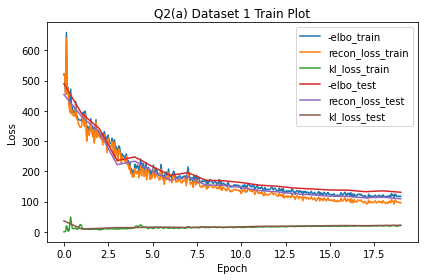

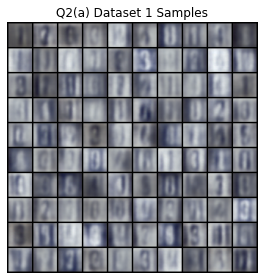

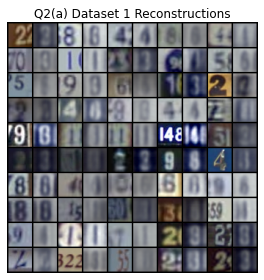

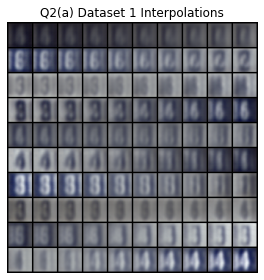

In [99]:
q2_save_results('a', 1, q2_a)


Final -ELBO: 241.8337, Recon Loss: 211.4157, KL Loss: 30.4180


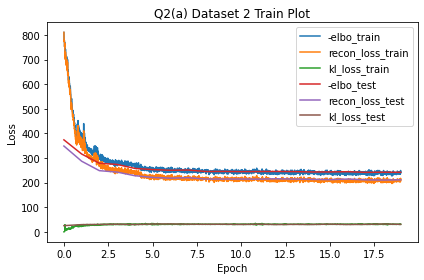

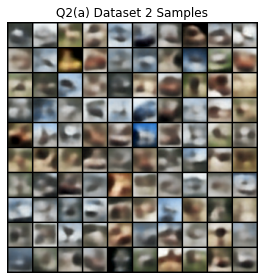

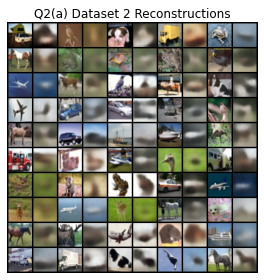

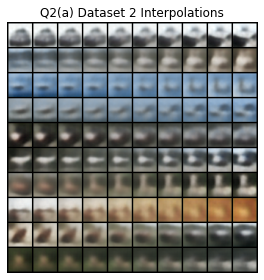

In [100]:
q2_save_results('a', 2, q2_a)